# HW1: Frame-Level Speech Recognition

In this homework, you will be working with MFCC data consisting of 28 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Libraries

In [37]:
!pip install torchsummaryX==1.1.0 wandb --quiet

In [38]:
# To ensure package compatibility
!pip install numpy==1.26.4

In [39]:
import torch
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [40]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [41]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"USERNAME","key":"KEY"}')
    # Put your kaggle username & key here

#!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory '/root/.kaggle': File exists


In [42]:
# commands to download data from kaggle
!kaggle competitions download -c 11785-hw1p2-f24

!unzip -qo /content/11785-hw1p2-f24.zip -d '/content'

401 - Unauthorized
unzip:  cannot find or open /content/11785-hw1p2-f24.zip, /content/11785-hw1p2-f24.zip.zip or /content/11785-hw1p2-f24.zip.ZIP.


In [43]:
#os.listdir()
#!unzip 11785-hw1p2-f24.zip -d /dev/shm

# Dataset

In [44]:
os.getcwd()
os.chdir("/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2")
os.listdir()

['test-clean', 'train-clean-100', 'dev-clean']

Before implementing the dataset class, let's take a look at one example MFCC/transcript pair:

Single MFCC file:


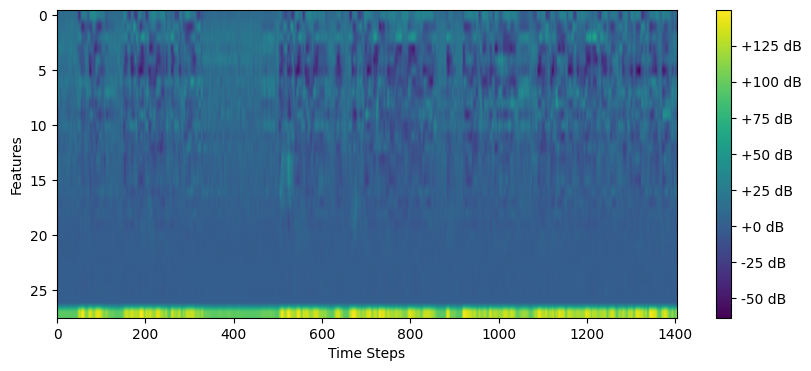

Single transcript file:

['[SOS]' '[SIL]' '[SIL]' '[SIL]' '[SIL]' '[SIL]'] ['[SIL]' '[SIL]' '[SIL]' ... '[SIL]' '[SIL]' '[EOS]']


In [45]:
def plot_mfcc(mfcc, title="Single MFCC File"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc.T, cmap='viridis', aspect='auto')
    #plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Load one MFCC file and one transcript file
mfcc_file = os.path.join('/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2/', 'train-clean-100/mfcc/103-1240-0000.npy')
transcript_file = os.path.join('/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2/', 'train-clean-100/transcript/103-1240-0000.npy')
mfcc = np.load(mfcc_file)
transcript = np.load(transcript_file)

# Visualize MFCC
print("Single MFCC file:")
plot_mfcc(mfcc)

# Print transcript
print("Single transcript file:\n")
print(transcript[:6],  transcript[7:])

In [46]:
# Dataset class to load train and validation data
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments
        self.context    = context
        self.phonemes   = phonemes
        # MFCC directory - use partition to access train/dev directories from kaggle data using root
        self.mfcc_dir       = os.path.join(root,partition,"mfcc/")
        # Transcripts directory - use partition to acces train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root,partition,"transcript/")
        # List files in sefl.mfcc_dir using os.listdir in sorted order
        mfcc_names          = os.listdir(self.mfcc_dir)
        mfcc_names.sort()
        # List files in self.transcript_dir using os.listdir in sorted order
        transcript_names    = os.listdir(self.transcript_dir)
        transcript_names.sort()
        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)
        self.mfccs, self.transcripts = [], []
        # Iterate through mfccs and transcripts
        for i in range(len(mfcc_names)):
        #   Load a single mfcc
            mfcc        = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc -= (np.mean(mfcc, axis=0))
            mfcc /= (np.std(mfcc, axis=0) + 1e-5)       
        #   Load the corresponding transcript
            transcript  = np.load(os.path.join(self.transcript_dir,transcript_names[i]))
        # Remove [SOS] and [EOS] from the transcript
            transcript = transcript[1:len(transcript)-1]
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...
        # Each transcript is of shape (T1+2), (T2+2) before removing [SOS] and [EOS]
        # Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        self.mfccs          = np.concatenate(self.mfccs)
        # Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        self.transcripts    = np.concatenate(self.transcripts)
        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)
        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame
        # We can introduce context by padding zeros on top and bottom of self.mfcc
        Z = np.zeros((context,28),dtype='float32')
        self.mfccs = np.concatenate([Z,self.mfccs,Z])
        # The available phonemes in the transcript are of string data type
        # But the neural network cannot predict strings as such.
        # Hence, we map these phonemes to integers
        # Map the phonemes to their corresponding list indexes in self.phonemes
        self.transcripts = np.array([PHONEMES.index(self.transcripts[i]) for i in range(len(self.transcripts))])
        # Now, if an element in self.transcript is 0, it means that it is 'SIL' (as per the above example)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        # Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames      = self.mfccs[ind:ind+2*self.context+1]
        # After slicing, you get an array of shape 2*context+1 x 28. But our MLP needs 1d data and not 2d.
        frames      = frames.flatten() # Flatten to get 1d data
        frames      = torch.FloatTensor(frames) # Convert to tensors
        phonemes    = torch.tensor(self.transcripts[ind])
        return frames, phonemes

In [47]:
class AudioTestDataset(torch.utils.data.Dataset):
    #pass
    # Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.
    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context = context
        self.phonemes = phonemes
        self.mfcc_dir = os.path.join(root,partition,"mfcc/")

        mfcc_names = os.listdir(self.mfcc_dir)
        mfcc_names.sort()
        self.mfccs = []

        for i in range(len(mfcc_names)):
            mfcc = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
            mfcc -= (np.mean(mfcc, axis=0))
            mfcc /= (np.std(mfcc, axis=0) + 1e-5)     
            self.mfccs.append(mfcc)
 
        self.mfccs = np.concatenate(self.mfccs)
        self.length = len(self.mfccs)
        Z = np.zeros((context,28),dtype='float32')
        self.mfccs = np.concatenate([Z,self.mfccs,Z])

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        frames = self.mfccs[ind:ind+2*self.context+1]
        frames = frames.flatten()
        frames = torch.FloatTensor(frames)
        return frames

# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [48]:
# CONTEXT default: 20
# batch_size default: 1024
# init_lr default: 1e-3

In [49]:
config = {
    # Dataset
    'batch_size'    : 512,
    'context'       : 20,
    # Model
    'architecture'  : 'aiming-high-cutoff',
    'drop'          : 0,
    # Training
    'checkpoint_dir': "/kaggle/working",
    'epochs'        : 5,
    'init_lr'       : 1e-3,
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

# Create Datasets

In [50]:
# Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset("/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2", context=config['context'])
# Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset("/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2", context=config['context'], partition="dev-clean")
# Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset("/kaggle/input/11785-hw1p2-f24/11785-f24-hw1p2", context=config['context'], partition="test-clean")

In [51]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader.
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)
print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  512
Context        :  20
Input size     :  1148
Output symbols :  42
Train dataset samples = 36091157, batches = 70491
Validation dataset samples = 1928204, batches = 3767
Test dataset samples = 1934138, batches = 3778


In [52]:
# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)
    break

torch.Size([512, 1148]) torch.Size([512])


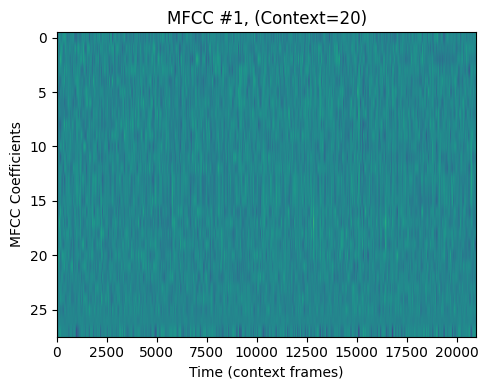

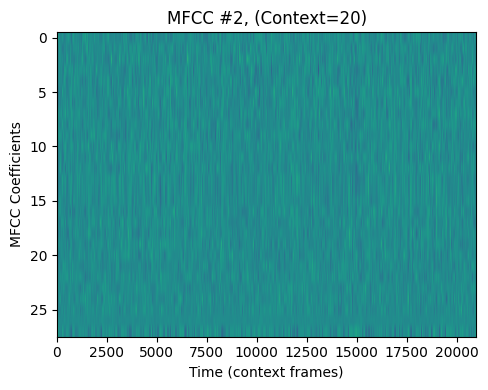

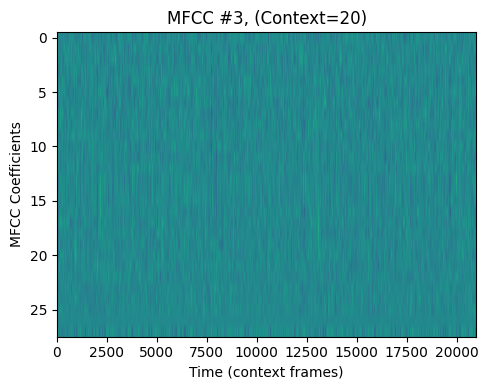

In [53]:
# Visualise a few MFCCs
for i, (frames, phonemes) in enumerate(train_loader):
    plt.figure(figsize=(5, 4))
    plt.imshow(frames.reshape(-1, 28).T, aspect='auto', cmap='viridis')
    plt.title(f'MFCC #{i+1}, (Context={config["context"]})')
    plt.xlabel('Time (context frames)')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    if i == 2:
        break

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [54]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
class Network(torch.nn.Module):

    def __init__(self, input_size, output_size):

        super(Network, self).__init__()

        self.model = torch.nn.Sequential(
            # Layer 1
            torch.nn.Linear(input_size, 360),
            torch.nn.BatchNorm1d(360),
            torch.nn.ReLU(),
            

            # Layer 2
            torch.nn.Linear(360, 360),
            torch.nn.BatchNorm1d(360),
            torch.nn.ReLU(),
            torch.nn.Dropout(config['drop']),

            # Output Layer 
            torch.nn.Linear(360, output_size)
        )

    def forward(self, x):
        out = self.model(x)

        return out

In [55]:
class DiamondNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(DiamondNetwork, self).__init__()
        self.model = torch.nn.Sequential(
            # Input layer
            torch.nn.Linear(input_size, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),

            torch.nn.Linear(100, 200),
            torch.nn.BatchNorm1d(200),
            torch.nn.ReLU(),

            # Hidden layers (peak)
            torch.nn.Linear(200, 400),
            torch.nn.BatchNorm1d(400),
            torch.nn.ReLU(),

            torch.nn.Linear(400, 200),
            torch.nn.BatchNorm1d(200),
            torch.nn.ReLU(),

            torch.nn.Linear(200, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),

            # Output layer
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.model(x)

input_size = 10
output_size = 2
model = DiamondNetwork(input_size, output_size)

In [56]:
class InversePyramidNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(InversePyramidNetwork, self).__init__()
        self.model = torch.nn.Sequential(
            # Input layer
            torch.nn.Linear(input_size, input_size//2),
            torch.nn.BatchNorm1d(input_size//2),
            torch.nn.ReLU(),

            torch.nn.Linear(input_size//2, input_size//4),
            torch.nn.BatchNorm1d(input_size//4),
            torch.nn.ReLU(),

            torch.nn.Linear(input_size//4, input_size//8),
            torch.nn.BatchNorm1d(input_size//8),
            torch.nn.ReLU(),

            # Output layer
            torch.nn.Linear(input_size//8, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [57]:
INPUT_SIZE  = (2*config['context'] + 1) * 28 # Why is this the case?
model       = InversePyramidNetwork(INPUT_SIZE, len(train_data.phonemes)).to(device)
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 20 million parameters for HW1 (including ensembles)

----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Linear                 [1148, 574]           [512, 574]               659.53                 0.66
1_BatchNorm1d                  [574]           [512, 574]                 1.15                 0.00
2_ReLU                             -           [512, 574]                    -                    -
3_Linear                  [574, 287]           [512, 287]               165.03                 0.16
4_BatchNorm1d                  [287]           [512, 287]                 0.57                 0.00
5_ReLU                             -           [512, 287]                    -                    -
6_Linear                  [287, 143]           [512, 143]                41.18                 0.04
7_BatchNorm1d                  [143]           [512, 143]                 0.29                 0.00

In [58]:
INPUT_SIZE

1148

In [59]:
len(train_data.phonemes)

42

In [60]:
model

InversePyramidNetwork(
  (model): Sequential(
    (0): Linear(in_features=1148, out_features=574, bias=True)
    (1): BatchNorm1d(574, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=574, out_features=287, bias=True)
    (4): BatchNorm1d(287, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=287, out_features=143, bias=True)
    (7): BatchNorm1d(143, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=143, out_features=42, bias=True)
  )
)

In [61]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

optimizer = torch.optim.Adam(model.parameters(), lr= config['init_lr']) #Defining Optimizer
# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html
scaler = torch.amp.GradScaler('cuda')

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. This code was provided.

In [62]:
torch.cuda.empty_cache()
gc.collect()

19409

In [63]:
def train(model, dataloader, optimizer, lr_scheduler, criterion, scaler):
    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    for i, (frames, phonemes) in enumerate(dataloader):
        ### Initialize Gradients
        optimizer.zero_grad()
        ### Move Data to Device (Ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)
         # forward
        with torch.amp.autocast('cuda'):  # This implements mixed precision. Thats it!
        ### Forward Propagation
            logits  = model(frames)
        ### Loss Calculation
            loss    = criterion(logits, phonemes)
        ### Backward Propagation
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        ### Gradient Descent
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        if lr_scheduler is not None:
            lr_scheduler.step()
        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]
        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                             acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()
        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()
    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)
    return tloss, tacc

In [64]:
def eval(model, dataloader):
    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    for i, (frames, phonemes) in enumerate(dataloader):
        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)
        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)
        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]
        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()
        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()
    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)
    return vloss, vacc

# Weights and Biases Setup

In [65]:
wandb.login(key="KEY") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [66]:
# Create your wandb run
run = wandb.init(
    name    = "test_with_batchnorm+invpyramid", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

lr,█▁
train_acc,▁█
train_loss,█▁
val_acc,▁█
valid_loss,█▁
lr,2e-05
train_acc,76.34886
train_loss,0.73085
val_acc,75.52866
valid_loss,0.75606


In [67]:
cd "/kaggle/working/"

/kaggle/working


In [68]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)
### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()
### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/tmp/wandb/run-20250213_163148-3jy8s7ob/files/model_arch.txt']

In [69]:
def save_model(model, optimizer, scheduler, train_acc, train_loss, val_acc, val_loss, curr_lr, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'train_acc'                : train_acc,
         'train_loss'               : train_loss,
         'val_acc'                  : val_acc,
         'val_loss'                 : val_loss,
         'lr'                       : curr_lr,
         'epoch'                    : epoch},
         path)

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [70]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")
best_val_acc = 0.0
eval_cls = True
for epoch in range(config['epochs']):
    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))
    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, scheduler, criterion, scaler)
    val_loss, val_acc       = eval(model, val_loader)
    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))
    ### Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})
    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    if eval_cls:
            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                save_model(model, optimizer, scheduler, train_acc*100, train_loss, val_acc*100, val_loss, curr_lr, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'), '/kaggle/')
                print("Saved best classification model")


Epoch 1/5


Train:   0%|          | 0/70491 [00:00<?, ?it/s]

Val:   0%|          | 0/3767 [00:00<?, ?it/s]

	Train Acc 72.6971%	Train Loss 0.8561	 Learning Rate 0.0010000
	Val Acc 74.3314%	Val Loss 0.7952
Saved best classification model

Epoch 2/5


Train:   0%|          | 0/70491 [00:00<?, ?it/s]

Val:   0%|          | 0/3767 [00:00<?, ?it/s]

	Train Acc 76.3133%	Train Loss 0.7327	 Learning Rate 0.0000199
	Val Acc 75.5818%	Val Loss 0.7540
Saved best classification model

Epoch 3/5


Train:   0%|          | 0/70491 [00:00<?, ?it/s]

Val:   0%|          | 0/3767 [00:00<?, ?it/s]

	Train Acc 77.2619%	Train Loss 0.7007	 Learning Rate 0.0009222
	Val Acc 76.0578%	Val Loss 0.7382
Saved best classification model

Epoch 4/5


Train:   0%|          | 0/70491 [00:00<?, ?it/s]

Val:   0%|          | 0/3767 [00:00<?, ?it/s]

	Train Acc 77.7882%	Train Loss 0.6830	 Learning Rate 0.0001693
	Val Acc 76.5922%	Val Loss 0.7210
Saved best classification model

Epoch 5/5


Train:   0%|          | 0/70491 [00:00<?, ?it/s]

Val:   0%|          | 0/3767 [00:00<?, ?it/s]

	Train Acc 78.1508%	Train Loss 0.6711	 Learning Rate 0.0007129
	Val Acc 76.7215%	Val Loss 0.7158
Saved best classification model


# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [71]:
def test(model, test_loader):
    model.eval() 
    ### List to store predicted phonemes of test data
    test_predictions = []
    ### Using inference mode to avoid gradients
    with torch.inference_mode(): 
        for i, mfccs in enumerate(tqdm(test_loader)):
            mfccs   = mfccs.to(device)
            logits  = model(mfccs)
            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim= 1) 
            test_predictions.append(predicted_phonemes)
    return test_predictions

In [72]:
predictions = test(model, test_loader)

  0%|          | 0/3778 [00:00<?, ?it/s]

In [73]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [74]:
### Finish your wandb run
run.finish()

lr,█▁▇▂▆
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▅▆██
valid_loss,█▄▃▁▁
lr,0.00071
train_acc,78.15075
train_loss,0.67108
val_acc,76.72154
valid_loss,0.71577


In [75]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
#!kaggle competitions submit -c 11785-hw1p2-f24 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

In [76]:
# Don't worry about submissions, it's going to fail as the deadline has passed.
# Aim to boost the train and val accuracy!